In [1]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/hasmitha/SP24/Practicum/Assignment-2


In [6]:
pip install mlxtend


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Load the data from the Excel file
file_path = '/Users/hasmitha/SP24/Practicum/Assignment-2/OnlineRetail.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [1]:
# Required Libraries
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Data Preprocessing
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dropna(subset=['CustomerID'], inplace=True)
data['CustomerID'] = data['CustomerID'].astype(int)

# Main Interface function
def recommend_items(cur_item_of_interest, customer_id, country, date):
    # Convert date string to datetime, and filter data
    date = pd.to_datetime(date).date()
    filtered_data = data[
        (data['CustomerID'] == customer_id) &
        (data['Country'] == country) &
        (data['InvoiceDate'].dt.date == date)
    ]
    
    # Adjust recency to be dynamic relative to the date provided
    recency_threshold = filtered_data['InvoiceDate'].max() - pd.Timedelta(days=30)
    recent_data = filtered_data[filtered_data['InvoiceDate'] >= recency_threshold]
    
    # Prepare the data for association rules mining
    basket = (recent_data
              .groupby(['InvoiceNo', 'Description'])['Quantity']
              .sum().unstack().fillna(0))
    basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
    
    # Generate frequent item sets and rules
    frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    
    # Enhance the recommendations by allowing broader matching
    rules['antecedents'] = rules['antecedents'].apply(lambda x: set(x))
    cur_item_set = set(cur_item_of_interest) if isinstance(cur_item_of_interest, list) else {cur_item_of_interest}
    recommendations = rules[rules['antecedents'].apply(lambda x: len(cur_item_set & x) > 0)]['consequents']
    
    # Return the recommended items sorted by confidence and lift
    return recommendations.sort_values(['confidence', 'lift'], ascending=[False, False])


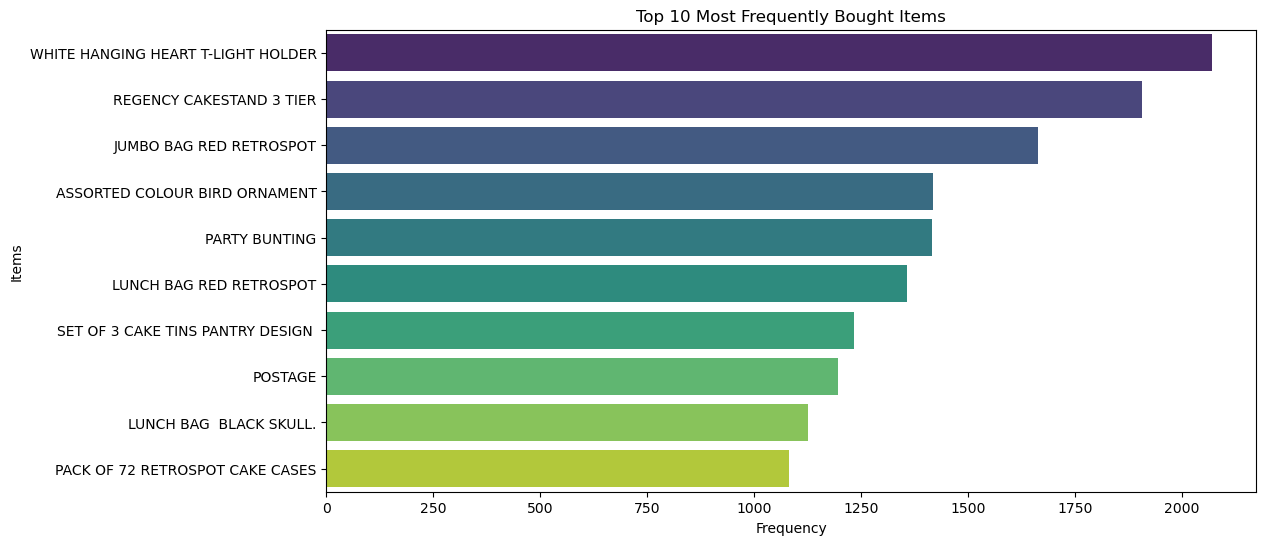

In [15]:
# Visualization and Insights
# 1. Most frequently bought items
plt.figure(figsize=(12, 6))
top_items = data['Description'].value_counts().head(10)
sns.barplot(x=top_items.values, y=top_items.index, palette='viridis')
plt.title('Top 10 Most Frequently Bought Items')
plt.xlabel('Frequency')
plt.ylabel('Items')
plt.show()

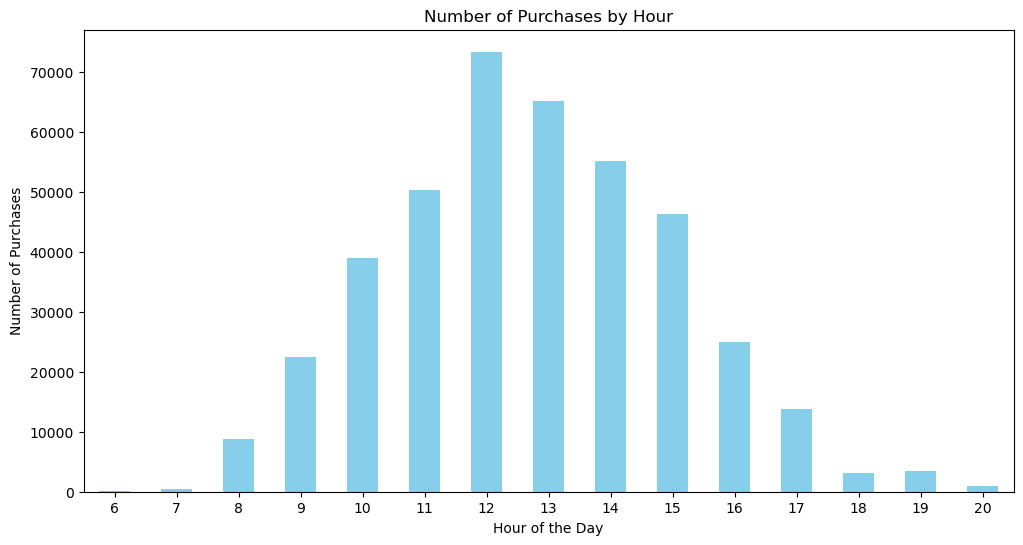

In [16]:
# 2. Most common purchase times
plt.figure(figsize=(12, 6))
sales_by_hour = data.groupby(data['InvoiceDate'].dt.hour).size()
sales_by_hour.plot(kind='bar', color='skyblue')
plt.title('Number of Purchases by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=0)
plt.show()

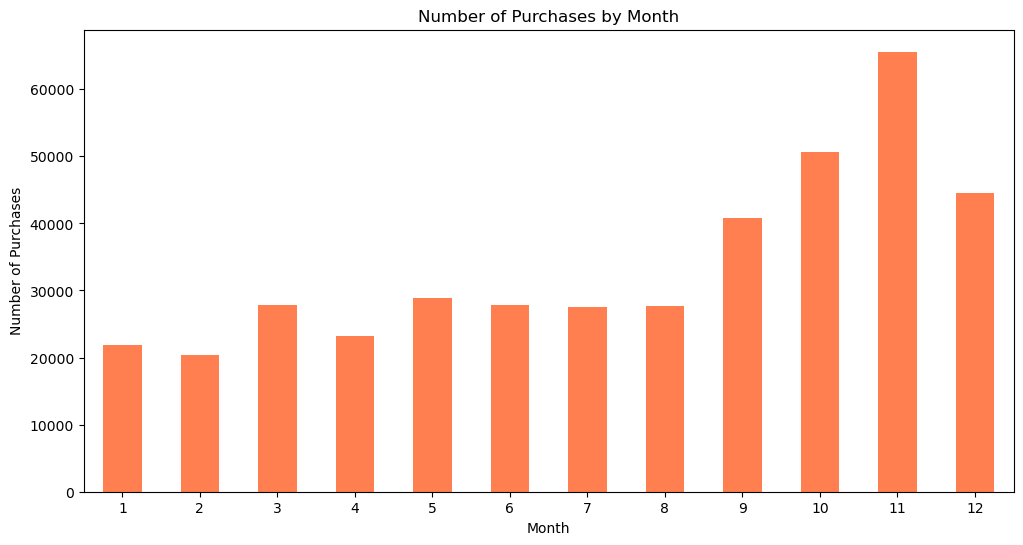

In [17]:
# 3. Most common purchase months
plt.figure(figsize=(12, 6))
sales_by_month = data.groupby(data['InvoiceDate'].dt.month).size()
sales_by_month.plot(kind='bar', color='coral')
plt.title('Number of Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=0)
plt.show()

In [18]:
# 4. Average order value during November and January
nov_jan_data = data[data['InvoiceDate'].dt.month.isin([11, 1])]
average_order_value = (nov_jan_data['Quantity'] * nov_jan_data['UnitPrice']).mean()
print(f"Average Order Value during November and January: {average_order_value:.2f}")


Average Order Value during November and January: 18.37


In [3]:
def calculate_score(recommended_items, actual_items):
    # Initialize score
    score = 0
    
    # Iterate over each recommended item
    for item in recommended_items:
        # If the item is in the actual items list, increment the score
        if item in actual_items:
            score += 1
    
    # Return the final score
    return score


In [4]:
# Example usage:
recommended_items = ['item1', 'item2', 'item3', 'item3', 'item5', 'item6']
actual_items = ['item3']
# Calculate the score
score = calculate_score(recommended_items, actual_items)
print(f"Recommendation Score: {score}")

Recommendation Score: 2


In [5]:
# Example usage:
recommended_items = ['item1', 'item2', 'item3', 'item3', 'item3', 'item6']
actual_items = ['item3']
# Calculate the score
score = calculate_score(recommended_items, actual_items)
print(f"Recommendation Score: {score}")

Recommendation Score: 3
